<a href="https://colab.research.google.com/github/ibader85/UnstructuredDataAnalytics/blob/main/19_Web_Scraping_Sports_Analytics_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

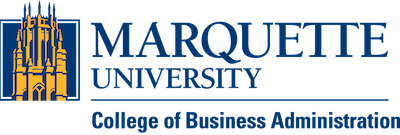



#BUAN4060: Unstructured Data Analytics

##19 Sports Analytics 2: Web Scraping

##Instructor: Dr. Badar Al Lawati "Dr. B"

**Acknowledgment:** This material is based on the content created by `Introduction to Sports Analytics using R by Ryan Elmore | Andrew Urbaczewski`[GitHub Page](https://github.com/rtelmore)

**R on Colab:**

* You can change the runtime from Python to R, by clicking on the down arrow next to Connect, and picking "Change Runtime Type"

* You can change the project name by clicking on the title on top of this page

* You can export your notebook by going to File > Download .ipynb

##1. Introduction

One reason that sports analytics has become so popular in the 21st century is the sheer volume of data about them that are collected and published

Data are readily available about players, teams, coaches, conferences, leagues, arenas, plays, and a myriad of other sport-specific characteristics

When combined with the publication and distribution ease of the Internet, these data are often readily available to anyone perusing the websites of sports-related entities

Just because we can see data on a web page, however, does not mean that they are available in a format that we can use for analysis in R or other programs

HyperText Markup Language (HTML), the language in which web pages are produced, does not integrate natively with most other statistical analysis programs

Trying to save a web page and then open it in Excel, or even copying and pasting the data elements, tends to be unreliable at best

So if we wish to take advantage of these vast data resources, we need to develop a more comprehensive strategy to get those data into a format we can use


One way we could take web data and put them into files for analysis in R would be to manually type in the data that we see on the screen into a data file

This will work, but it is tedious, time consuming, and prone to transcription error, so we would prefer not to use this method

## 2. Web Scraping and Ethics

Before we go any further, we must mention that the practice of web scraping can be controversial

Some websites welcome the practice, others turn a blind eye, and yet others even put in active countermeasures to try to prohibit someone from scraping the data for use off of the hosting website

We suggest that if you are scraping data from a website, you should at least try to find out if scraping is actively discouraged on the site and, if so, avoid scraping on that property

A relatively simple way to check the rules on scraping a particular website is to examine its affinity toward web scrapers and automated crawling of the site

It will list its preferences in a file in its root folder called robots.txt

These are instructions from the website to automated programs, like web crawlers for search engines, that tell these programs what directories and files it gives its permission to be downloaded and indexed and which ones it does not want to be indexed through the use of the disallow nomenclature

Here are the contents of the robots.txt file from NFL.com in June 2023 (see https://www.nfl.com/robots.txt):

User-agent: *

Disallow: /_ctv/

Disallow: /_fantasy-app/

Disallow: /_libraries/

Disallow: /_mobile-app/

Disallow: /_mobileview/

Disallow: /_phs/

Disallow: /_sponsors/

Disallow: /account/

Disallow: /nfl-films-beta/

Disallow: /search/

Sitemap: https://www.nfl.com/sitemap-index.xml

User-agent: Mediapartners-Google

Disallow: /stats/player-stats/*

##3. Web Document Structure

Before we can understand how to get the data out of a web page, we need to understand the structure of a web page

Web pages are HTML documents, which are somewhat akin to Markdown documents in that they are written as plain text with instructions for displaying the text within the documents

Each chunk of text is called a node, and each node is encapsulated within a pair of tags, which are represented between < and > characters. So that is to say that `<sample>` and `</sample>` are the tags that mark the beginning and ending of a node

There are many different tags, such as `<p>` for a paragraph, `<b>` for bold, `<i>` for italic, and `<u>` for underline

However, we need to concern ourselves especially with the tags that are used to display data tables, as the data we seek will most often be stored in a table

The below Table presents a list of common table-related tags and descriptions

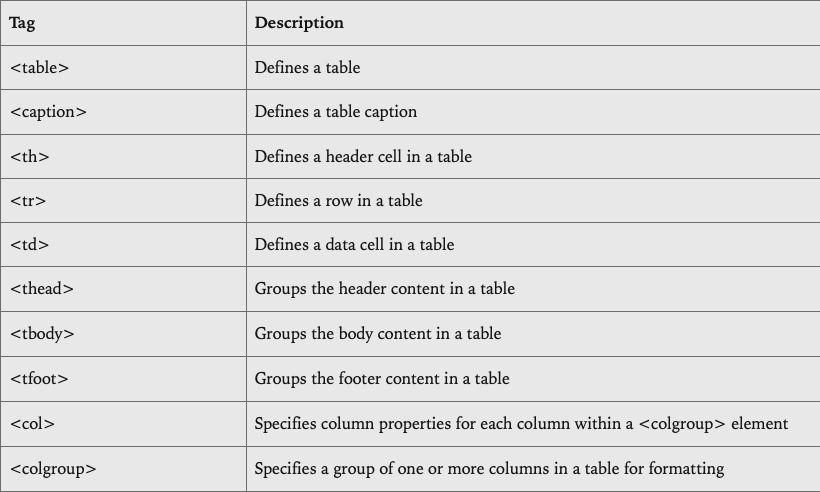

Tables have rows, and the rows have cells

The cells can be either header cells or data cells

A sample table from https://w3schools.com that we might scrape could look like the following:
        
          <table style="width:100%">
          <tr>
          <th>Firstname</th>
          <th>Lastname</th>
          <th>Age</th>
          </tr>
          <tr>
          <td>Jill</td>
          <td>Smith</td>
          <td>50</td>
          </tr>
          <tr>
          <td>Eve</td>
          <td>Jackson</td>
          <td>94</td>
          </tr>
          </table>
        
Note that this table has the attribute “style,” and it is set to “width:100%.” This means that the table will by default expand or contract to exactly fill the screen of the viewer

Many other attributes are available for <table> and other tags as well
      
      
        

##4. Web Scraping in R

We will use the `rvest()` package (like harvest) to implement web scraping techniques

In [1]:
install.packages("dplyr")
install.packages("ggplot2")
install.packages("xml2") # allows us to interact with webpages by parsing XML
install.packages("rvest") # helps us to harvest (scrape) data from web pages
install.packages("janitor") # a set of tools to examine and clean dirty data

library(dplyr)
library(ggplot2)
library(xml2)
library(rvest)
library(janitor)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘snakecase’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




##5. Scrping NHL Data

As an example of web scraping, we will look at how we might obtain NHL data from the web and convert them into a format where we can analyze them

To do this, we will look at the website hockeyreference.com and attempt to get all of the data Hockey Reference collects for the 2022-23 Colorado Avalanche players and put them into data frames we can analyze in R

To achieve this goal, we would like to complete the following two specific tasks:
   1. Download the roster table into a format we can use for R.
   2. Obtain the information from the individual player links.
        
As of this writing, this information can be found on the web at http://www.hockey-reference.com/teams/COL/2023.html

Of course, this could change at a moment's notice, as we have no control over that website directly, which is a problem that analysts face in obtaining data repeatedly

In [2]:
team <- "COL" # Define a team
year <- 2023 # Define a Year
url <- paste("http://www.hockey-reference.com/teams/",
            team,
            "/",
            year,
            ".html",
            sep = "") # Construct a custom URL
pg <- read_html(url) # Read the html content

tables <- pg |> # extract the html tables
  html_table()

At this point, you may want to visit the website for this particular page and see what we are trying to put into a data frame for R analysis

Open a web browser and go to https://www.hockey-reference.com/teams/COL/2023.html. We can see by scrolling that this is a very long page with a few hyperlinks near the bottom of our initial view to help us jump to the information we want

If we click on the link for “Roster,” it will take us farther down the page to the roster table

There are also hyperlinks for each player in the table. If we want to see information about Nathan MacKinnon, we can click on his name

But for now, it is this table that we want to scrape

It may help you also to look at the page source. You may recall that HTML is simply a markup language, a cousin to R Markdown that we discussed in the previous chapter

HTML provides a web browser with instructions on how to display the text contained within the document. To view the raw document code that the page creator used, you can right-click on the page and choose “View Page Source” (in Google Chrome; other web browsers will allow you to see this as well but will have their own method for displaying the page source)

A new tab will open displaying the HTML code

The page for the Colorado Avalanche 2022-23 season is over 5,000 lines long!

We need to find where the roster table is in this document

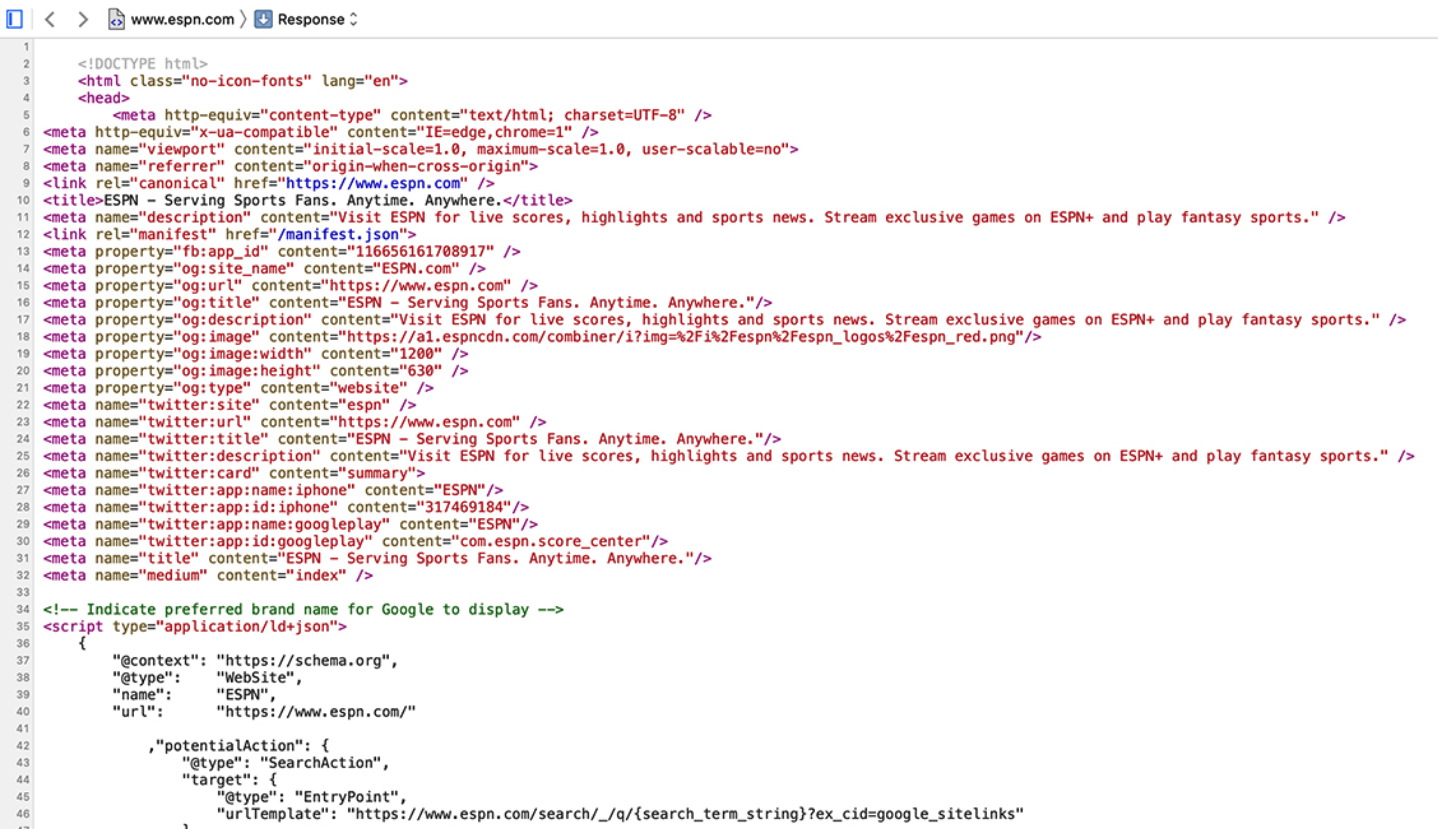

Since tables are contained in HTML nodes (or tags) that contain <table>, we need to search for table in the document

Just searching for the word table will return over 100 results, but if you instead search for `<table` (without the > sign, since there are many variables within the table tag, but it will always start with `<table)`, it will return only the tables

Go through the results until you find the one related to rosters. You will see that it has id=roster in the tag as an attribute of the table, meaning that the document refers to that table by the ID roster

Now we are ready to get the information for our players

In the following code block, we read the website's HTML as described and then identify the tag in the roster table using the `html_nodes()` function to identify the table with the desired tag, using xpath and indicated in this case by "roster"

The third line extracts the href (hypertext reference) attributes in the table, which in this case will be the unique links to each player's information on hockey-reference.com:

In [3]:
links <- pg |>
  html_nodes(xpath = '//*[(@id = "roster")]//a') |> # Finds all HTML nodes (elements) that match the given XPath query.
  html_attr('href') # Retrieve the value of the href attribute from each <a> tag found

# XPath Query ('//*[(@id = "roster")]//a'):
	# //*: Search for all elements in the document.
	#	[@id = "roster"]: Restricts the search to elements with id="roster".
	#	//a: Selects all anchor (<a>) tags inside the element with id="roster".
	#	This means it is looking for links within the roster section of the webpage.

In [4]:
links

[1] "/players/a/annunju01.html" "/players/b/blidhan01.html"
 [3] "/players/b/bowersh01.html" "/players/b/burkeca01.html"
 [5] "/players/b/byrambo01.html" "/players/c/coglian01.html"
 [7] "/players/c/comphj.01.html" "/players/e/ellerla01.html"
 [9] "/players/e/engluan01.html" "/players/f/foudyje01.html"
[11] "/players/f/francpa01.html" "/players/g/galchal01.html"
[13] "/players/g/georgal01.html" "/players/g/girarsa01.html"
[15] "/players/h/helmda01.html"  "/players/h/hudonch01.html"
[17] "/players/h/huntbr01.html"  "/players/h/huntdr01.html" 
[19] "/players/j/johanjo03.html" "/players/j/johnser01.html"
[21] "/players/j/johnsja02.html" "/players/k/kautma01.html" 
[23] "/players/k/kinkake01.html" "/players/l/lehkoar01.html"
[25] "/players/m/macdeku01.html" "/players/m/macdoja02.html"
[27] "/players/m/mackina01.html" "/players/m/makarca01.html"
[29] "/players/m/malgide01.html" "/players/m/maltsmi01.html"
[31] "/players/m/mansojo01.html" "/players/m/megnaja01.html"
[33] "/players/m/meyerbe01.html" "/players/n/newhoal01.html"
[35] "/players/n/nichuva01.html" "/players/n/nietoma01.html"
[37] "/players/o/oconnlo01.html" "/players/o/olausos01.html"
[39] "/players/r/rantasa01.html" "/players/r/rantami01.html"
[41] "/players/r/rodriev01.html" "/players/s/sedlalu01.html"
[43] "/players/t/toewsde01.html"

Now that we can examine the structure of the URLs that hold the player-specific information, we can run the code below to acquire a specific player’s information

You may notice that this could break depending on the time at which you are trying to scrape the data

If you are getting something that looks unusual, try to decipher what got scraped instead of what you were hoping for and adjust accordingly:

In [10]:
# Parse the table from the webpage
url <- "https://www.hockey-reference.com/players/m/mackina01.html"
mac_tbs <- rvest::read_html(url) |> rvest::html_table()

# Select the correct table
mac_tb <- mac_tbs[[1]]

# Set the first row as column names
mac_tb <- mac_tb |> janitor::row_to_names(row_number = 1)

# Clean the column names
mac_tb <- mac_tb |> janitor::clean_names()

# Ensure the date column exists and is character
mac_tb <- mac_tb |>
  dplyr::mutate(date = as.character(date))

# Filter rows
mac_tb <- mac_tb |>
  dplyr::filter(!(date %in% c("Career", "82 Game Avg.")))

# View the cleaned table
head(mac_tb)

Warning message:
“Row 1 does not provide unique names. Consider running clean_names() after row_to_names().”


date,team,x,opp,result,g,a,pts,x_2,pim,⋯,sh,sog,spct,shft,toi,hit,blk,fow,fol,fo_percent
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2024-11-18,COL,@,PHI,W 3-2,0,1,1,0,6,⋯,0,2,0.0,27,22:39,0,0,11,7,61.1
2024-11-15,COL,,WSH,L 2-5,0,0,0,-2,0,⋯,0,0,,24,22:06,0,0,10,10,50.0
2024-11-13,COL,,LAK,W 4-2,0,3,3,3,0,⋯,0,3,0.0,27,24:45,1,0,6,16,27.3
2024-11-11,COL,,NSH,W 3-2 (OT),0,1,1,1,0,⋯,0,5,0.0,30,24:29,0,0,6,8,42.9
2024-11-09,COL,,CAR,W 6-4,1,3,4,3,0,⋯,0,7,14.3,28,26:19,0,0,11,11,50.0


In [17]:
# Read the main page and extract links
page <- rvest::read_html("https://www.hockey-reference.com/players/m/mcdavco01.html")
links <- page |>
  rvest::html_nodes("a") |>
  rvest::html_attr("href")

# Ensure links[27] is valid
if (length(links) >= 27) {
  url <- paste("https://www.hockey-reference.com", links[27], sep = "")

  # Parse the URL and extract tables
  mac_tbs <- rvest::read_html(url) |>
    rvest::html_table()

  # Ensure the third table exists
  if (length(mac_tbs) >= 3) {
    mac_tb <- mac_tbs[[3]] |>
      janitor::clean_names()

    # Dynamically adapt filtering if 'season' exists
    if ("season" %in% colnames(mac_tb)) {
      mac_tb <- mac_tb |>
        dplyr::filter(!(season %in% c("Career", "82 Game Avg.")))
    } else {
      warning("The table does not contain a 'season' column.")
    }

    # Display results
    print(head(mac_tb))
  } else {
    stop("Error: The webpage does not contain a third table.")
  }
} else {
  stop("Error: The `links` object does not contain enough elements.")
}

Warning message:
“The table does not contain a 'season' column.”


# A tibble: 2 × 3
  x1                    x2 x3   
  <chr>              <int> <chr>
1 New York Islanders     1 Final
2 Calgary Flames         2 SO   


You may also notice that we clean up the data a bit as well using the `janitor()` package's `clean_names()` function

In particular, `clean_names()` removes symbols from column names (e.g., +/-), changes the names to lowercase, and does other formatting representative of generally accepted programming practices

Finally, we run a filter from the `dplyr()` library to get the information for their season and career

We can wrap the code given above into a function so that we can download those player links for any team:

In [18]:
library(rvest)
library(dplyr)
library(tibble)

get_hrc_player_links <- function(team, year = 2023) { # retrieve the roster information for a specified hockey team and season
  url <- paste0("https://www.hockey-reference.com/teams/", team, "/", year, ".html") # Combines the base URL of the site with the team abbreviation defined earlier
  pg <- read_html(url)

  # Locate all links (<a> elements) in the roster table (identified by id="roster") and extract their href attributes
  links <- pg |>
    html_nodes("#roster a") |>  # Updated selector
    html_attr("href")

  if (length(links) == 0) {
    stop("Error: No links found under the roster table.")
  }

  # Extract the roster table and bind links
  teams_data <- pg |>
    html_table()

  if (length(teams_data) >= 3) {
    teams_data <- teams_data[[3]] |> # Take the third table (the roster table) and binds a new column containing the links (links) for each player
      bind_cols(tibble(links = links[1:nrow(teams_data[[3]])]))  # Ensure that the number of rows in the table matches the number of links
  } else {
    stop("Error: The webpage does not contain the expected roster table.")
  }

  return(teams_data)
}

# Test the function
col_data <- get_hrc_player_links("COL", year = 2023)
head(col_data)

No.,Player,Birth,Pos,Age,Ht,Wt,S/C,Exp,Birth Date,Summary,links
<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
60,Justus Annunen,fi FI,G,22,6-4,210,-/L,1,"March 11, 2000","1-1-0, 3.58 GAA",/players/a/annunju01.html
36,Anton Blidh,se SE,LW,27,6-1,196,L/-,6,"March 14, 1995","0 G, 0 A, 0 P",/players/b/blidhan01.html
15,Shane Bowers,ca CA,C,23,6-2,186,L/-,R,"July 30, 1999","0 G, 0 A, 0 P",/players/b/bowersh01.html
68,Callahan Burke,us US,C,25,5-10,183,R/-,R,"March 19, 1997","0 G, 0 A, 0 P",/players/b/burkeca01.html
4,Bowen Byram,ca CA,D,21,6-1,190,L/-,2,"June 13, 2001","10 G, 14 A, 24 P",/players/b/byrambo01.html
11,Andrew Cogliano,ca CA,LW/C,35,5-10,179,L/-,15,"June 14, 1987","10 G, 9 A, 19 P",/players/c/coglian01.html


### What's so important about what we just did?

1.	Dynamic Roster Scraping: The function dynamically fetches the latest roster data, including the links to player pages
2.	Player Analysis: The links column allows you to dive deeper into individual player statistics by visiting their respective pages
3.	Versatile Use Case: You can use this function for different teams and years by adjusting the team and year parameters

##6. Writing Custom Function (Loops and Web Scraping)

You can already see the power of web scraping, but what if we want to expand this?, the logic we use may seem a bit tedious for creating a single URL for Colorado Avalanche players

However, what if we wanted data not from one team and one season but from multiple teams and multiple seasons?

Let's say that we wanted to get the Colorado Avalanche and Dallas Stars information for the 2021-22 and 2022-23 seasons

To do this, we need to iterate over two teams and two seasons

We can then take the code that we created earlier and put it inside of a loop so that it can be repeated as many times as necessary

This process will be much cleaner if we write a custom function so that we only need to write the code once and have it repeat for each team

Let's call that function get_nhl_roster(team, season)

This function will then return to us the roster for the year that we specify as the first argument and the team that we specify in the second argument

It also sets a default of 2023 for the year so that if we do not supply an argument for year, it will give us the 2023 roster:

In [19]:
get_nhl_roster <- function(team, season = 2023){
  url <- paste("http://www.hockey-reference.com/teams/",
              team, "/", season, ".html", sep = "")
  tb <- read_html(url) |>
    html_table()
  tb <- tb[[3]]
  return(tb)
}

To test that the function works, let's pull just the Colorado Avalanche data from 2023 and put it into a data frame called col_df:

In [20]:
col_df <- get_nhl_roster(team = "COL", season = 2023)

Well, that seemed to work. So now let's run it in the loop

We will have two loops, one for the two teams that we placed inside of the vector teams, and inside of that loop, we will have another loop that pulls the data for each of the seasons we requested when we created the vector years

The below example will give us all of the data for Colorado first, and then it will retrieve the data for Dallas:

In [21]:
teams <- c("COL", "DAL")
years <- 2022:2023
for(i in seq_along(teams)){
  for(j in seq_along(years)){
    tb <- get_nhl_roster(teams[i], years[j]) |>
      mutate(team = teams[i],
    year = years[j])
    if(exists("results")){
      results <- rbind(results, tb)
    }else(results <- tb)
  }
}

So now we have written all of the team data from Colorado and Dallas to the data frame results, and we can use this in future analysis